In [1]:
# Import Required Libraries
import numpy as np
import zlib
import pickle
from matplotlib import pyplot as plt
from scipy.optimize import minimize, basinhopping
from sklearn.datasets import make_circles
from tqdm.notebook import tqdm
import operator
from scipy.special import digamma
from sklearn.neighbors import KDTree, BallTree


import sys 
sys.path.append("/home/bukkacha/Desktop/Inductive bias/src")
from symreg import SymReg, evaluate_composition, DEFAULT_OPERATIONS, Node, Composition, evaluate_tree


import warnings
warnings.filterwarnings('ignore')

In [3]:
# mutual information
def add_noise(x, intens=1e-10):
    # small noise to break degeneracy, see doc.
    return x + intens * np.random.random_sample(x.shape)

def build_tree(points):
    if points.shape[1] >= 20:
        return BallTree(points, metric='chebyshev')
    return KDTree(points, metric='chebyshev')

def count_neighbors(tree, x, r):
    return tree.query_radius(x, r, count_only=True)

def avgdigamma(points, dvec):
    # This part finds number of neighbors in some radius in the marginal space
    # returns expectation value of <psi(nx)>
    tree = build_tree(points)
    dvec = dvec - 1e-15
    num_points = count_neighbors(tree, points, dvec)
    return np.mean(digamma(num_points))

def query_neighbors(tree, x, k):
    return tree.query(x, k=k + 1)[0][:, k]

def mi(x, y, z=None, k=3, base=2):
    """ Mutual information of x and y (conditioned on z if z is not None)
        x, y should be a list of vectors, e.g. x = [[1.3], [3.7], [5.1], [2.4]]
        if x is a one-dimensional scalar and we have four samples
    """
    assert len(x) == len(y), "Arrays should have same length"
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    x, y = np.asarray(x), np.asarray(y)
    x, y = x.reshape(x.shape[0], -1), y.reshape(y.shape[0], -1)
    x = add_noise(x) #add noise to both of x and y
    y = add_noise(y)
    points = [x, y]
    if z is not None:
        z = np.asarray(z)
        z = z.reshape(z.shape[0], -1)
        points.append(z)
    points = np.hstack(points)
    # Find nearest neighbors in joint space, p=inf means max-norm
    tree = build_tree(points)
    dvec = query_neighbors(tree, points, k)
    if z is None:
        a, b, c, d = avgdigamma(x, dvec), avgdigamma(
            y, dvec), digamma(k), digamma(len(x))
    else:
        xz = np.c_[x, z]
        yz = np.c_[y, z]
        a, b, c, d = avgdigamma(xz, dvec), avgdigamma(
            yz, dvec), avgdigamma(z, dvec), digamma(k)
    return (-a - b + c + d) / np.log(base)

In [4]:
n_samples = 100

Task 1

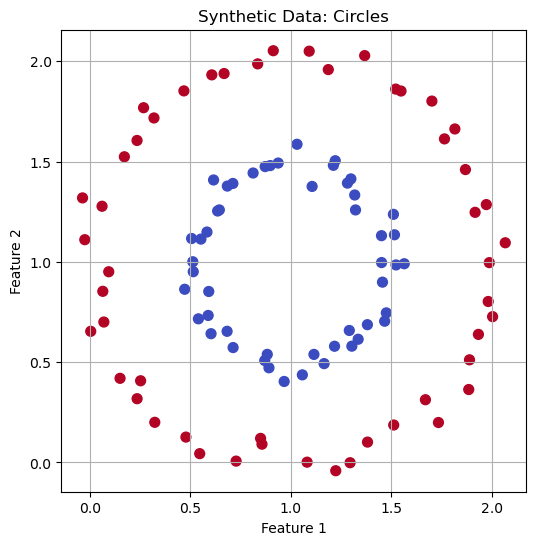

In [5]:
X_clf, y_clf = make_circles(
    n_samples=n_samples, 
    noise=0.05, 
    factor=0.5, 
    random_state=23
)
X_clf = X_clf + np.array([1, 1])
y_clf = np.where(y_clf == 0, 1, 0)

# plot the data
plt.figure(figsize=(6, 6))
plt.scatter(X_clf[:, 0], X_clf[:, 1], c=y_clf, cmap='coolwarm', s=50)
plt.title("Synthetic Data: Circles")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid()
plt.show()

Task 2

Text(0, 0.5, 'Feature 2')

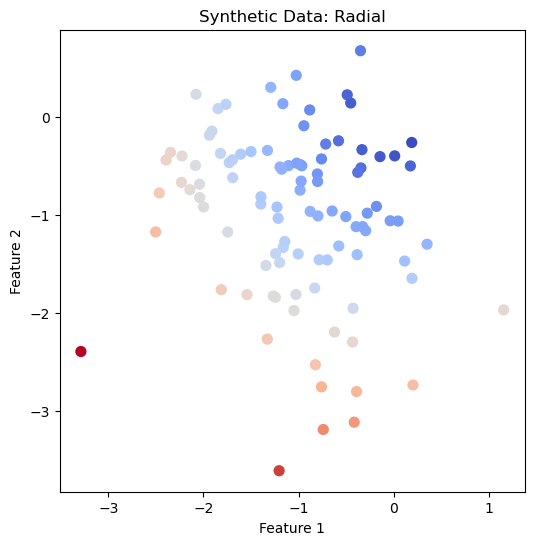

In [6]:
X_rad, _ = make_circles(
    n_samples=n_samples, 
    noise=0.6, 
    factor=0.5, 
    random_state=22
)
X_rad = X_rad + np.array([-1, -1])
y_rad = np.sqrt(X_rad[:, 0]**2 + X_rad[:, 1]**2) + 0.5
# plot circles 
plt.figure(figsize=(6, 6))
plt.scatter(X_rad[:, 0], X_rad[:, 1], c=y_rad, cmap='coolwarm', s=50)
plt.title("Synthetic Data: Radial")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

Task 3

Text(0, 0.5, 'Feature 2')

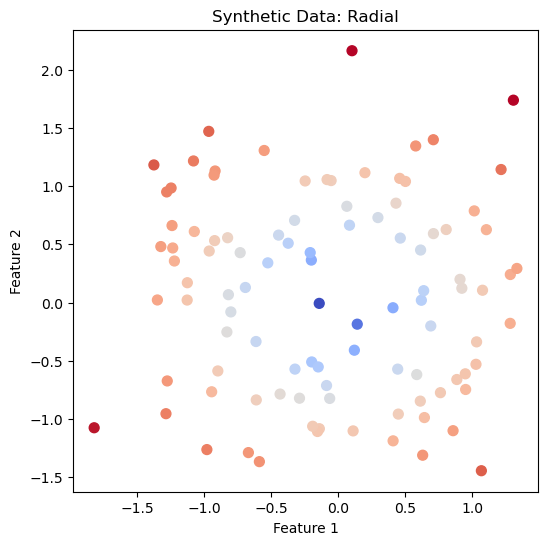

In [7]:
X_force, _ = make_circles(
    n_samples=n_samples, 
    noise=0.5, 
    factor=0.8, 
    random_state=30
)
y_force = np.sqrt(np.sqrt(X_force[:, 0]**2 + X_force[:, 1]**2)) - 0.5
plt.figure(figsize=(6, 6))
plt.scatter(X_force[:, 0], X_force[:, 1], c=y_force, cmap='coolwarm', s=50)
plt.title("Synthetic Data: Radial")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

In [8]:
X_all = np.concatenate((X_clf, X_rad, X_force), axis=0)
y_all = np.concatenate((y_clf, y_rad, y_force), axis=0)

In [9]:
from symreg import DEFAULT_OPERATIONS as DO
DO

{'add': (<function _operator.add(a, b, /)>, 2),
 'mult': (<function _operator.mul(a, b, /)>, 2),
 'sub': (<function _operator.sub(a, b, /)>, 2),
 'sin': (<ufunc 'sin'>, 1),
 'cos': (<ufunc 'cos'>, 1),
 'exp': (<ufunc 'exp'>, 1),
 'log': (<function symreg.safe_log(x)>, 1),
 'max': (<ufunc 'maximum'>, 2),
 'sqrt': (<ufunc 'sqrt'>, 1),
 'square': (<ufunc 'square'>, 1)}

In [3]:
from operator import add, sub, mul

    
def square(x):
    return x**2

In [4]:
DEFAULT_OPERATIONS = {
    'add': (operator.add,2),
    'sub': (operator.sub,2),
    'mult': (operator.mul,2),
    'sqrt': (np.sqrt, 1),
    'square': (square, 1)
}

# Ground truth


In [5]:
def compress_score(expression_str: str):
    compressed = zlib.compress(expression_str.encode('utf-8'))
    return len(compressed)


def compress_hiddens(composition):
    return compress_score(';'.join([
        h.polish(DEFAULT_OPERATIONS) for h in composition.children_h]))

def compute_accuracy(model, X, y, pool):
    variables = {f'x{i}': X[:, i] for i in range(X.shape[1])}
    predictions = evaluate_composition(model, variables, pool, DEFAULT_OPERATIONS, g_id=0) > 0
    accuracy = np.equal(predictions, y).mean()
    return accuracy  

def compute_mse(model, X, y, pool, g_id):
    variables = {f'x{i}': X[:, i] for i in range(X.shape[1])}
    predictions = evaluate_composition(model, variables, pool, DEFAULT_OPERATIONS, g_id=g_id)
    mse = ((predictions - y)**2).mean()
    return mse 

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def min_func_task1(x0, var_y):
    var_, y_, model = var_y
    pool_ = {f'p{i}': x0[i] for i in range(len(x0))}
    y_pred = evaluate_composition(model, var_, pool_, DEFAULT_OPERATIONS, g_id=0)
    errs = -np.mean(y_ * np.log(sigmoid(y_pred) + 1e-15) + (1 - y_) * np.log(1 - sigmoid(y_pred) + 1e-15))
    return errs

def min_func_task2(x0, var_y):
    var_, y_, model = var_y
    pool_ = {f'p{i}': x0[i] for i in range(len(x0))}
    y_pred = evaluate_composition(model, var_, pool_, DEFAULT_OPERATIONS, g_id=1)
    errs = ((y_pred - y_)**2).mean()
    return errs

def min_func_task3(x0, var_y):
    var_, y_, model = var_y
    pool_ = {f'p{i}': x0[i] for i in range(len(x0))}
    y_pred = evaluate_composition(model, var_, pool_, DEFAULT_OPERATIONS, g_id=2)
    errs = ((y_pred - y_)**2).mean()
    return errs


def mymi(x1, x2):
    x1 = np.array(x1)
    x1 = (x1-x1.mean(0))/(1e-10+x1.std(0))
    x2 = np.array(x2)
    x2 = (x2-x2.mean(0))/(1e-10+x2.std(0))
    return mi(x1, x2)


def compute_mi(ind, x, y, pool, OPERATIONS):
    hidden_matrix = []
    for h in ind.children_h:
        h_pred = evaluate_tree(h, x | pool, OPERATIONS)

        if np.isscalar(h_pred) or np.isnan(h_pred).any():
            h_pred = np.zeros((n_samples))

        hidden_matrix.append(h_pred)

    hidden_matrix = np.stack(hidden_matrix).squeeze().T

    x_np = np.array([v for k, v in x.items()]).T

    return mymi(x_np, hidden_matrix), mymi(hidden_matrix, y)


In [6]:


def get_composition():
    x0 = Node('x0')
    x1 = Node('x1')
    p0 = Node('p0')
    p1 = Node('p1')
    p2 = Node('p2')
    h0_ = Node('h0')
    h1_ = Node('h1')
    h0 = Node('add', [x0, p0])
    h0 = Node('square', [h0])
    h1 = Node('add', [x1, p1])
    h1 = Node('square', [h1])
    # g0 = Node('add', [Node('sqrt', [Node('add', [h0_, h1_])]), p2])
    g0 = Node('add', [Node('add', [h0_, h1_]), p2])
    p3 = Node('p3')
    g1 = Node('add', [Node('sqrt', [Node('add', [h0_, h1_])]), p3])
    p4 = Node('p4')
    g2 = Node('add', [Node('sqrt', [Node('sqrt', [Node('add', [h0_, h1_])])]), p4])
    comp = Composition([h0, h1], [g0, g1, g2])
    return comp

composition = get_composition()
print(composition)


h_0 = square(add(x0, p0))
h_1 = square(add(x1, p1))
g_0 = add(add(h0, h1), p2)
g_1 = add(sqrt(add(h0, h1)), p3)
g_2 = add(sqrt(sqrt(add(h0, h1))), p4)


Metrics before parameter optimization

In [17]:
pool = {f'p{i}': np.random.uniform(-2, 2) for i in range(5)}

mi_score = compute_mi(
    composition, 
    {f'x{i}': X_clf[:, i] for i in range(X_clf.shape[1])}, 
    y_clf,
    pool, 
    DEFAULT_OPERATIONS,
)[0]
acc = compute_accuracy(composition, X_clf, y_clf, pool)
comp = compress_hiddens(composition)
print("Task 1:")
print(f"\tMutual Information: {mi_score}")
print(f"\tAccuracy: {acc}")

mi_score = compute_mi(
    composition, 
    {f'x{i}': X_rad[:, i] for i in range(X_rad.shape[1])}, 
    y_rad,
    pool, 
    DEFAULT_OPERATIONS,
)[0]
mse = compute_mse(composition, X_rad, y_rad, pool, 1)
comp = compress_hiddens(composition)
print("Task 2:")
print(f"\tMutual Information: {mi_score}")
print(f"\tMSE: {mse}")


mi_score = compute_mi(
    composition, 
    {f'x{i}': X_force[:, i] for i in range(X_force.shape[1])}, 
    y_force,
    pool, 
    DEFAULT_OPERATIONS,
)[0]
mse = compute_mse(composition, X_force, y_force, pool, 2)
comp = compress_hiddens(composition)
print("Task 2:")
print(f"\tMutual Information: {mi_score}")
print(f"\tMSE: {mse}")

Task 1:
	Mutual Information: 4.597520641209583
	Accuracy: 0.5
Task 2:
	Mutual Information: 2.5679674645771047
	MSE: 6.52513673073425
Task 2:
	Mutual Information: 3.158518137226806
	MSE: 0.3979498264606089


In [32]:
x_opt = minimize(
    min_func_task1,
    list({f'p{i}': np.random.uniform(-1, 1) for i in range(5)}.values()),
    args=([{f'x{i}': X_clf[:, i] for i in range(X_clf.shape[1])}, y_clf, composition],),
)
pool_task1 = {f'p{i}': x_opt.x[i] for i in range(len(x_opt.x))}

x_opt = minimize(
    min_func_task2,
    list({f'p{i}': np.random.uniform(-1, 1) for i in range(5)}.values()),
    args=([{f'x{i}': X_rad[:, i] for i in range(X_rad.shape[1])}, y_rad, composition],),
)
pool_task2 = {f'p{i}': x_opt.x[i] for i in range(len(x_opt.x))}


x_opt = minimize(
    min_func_task3,
    list({f'p{i}': np.random.uniform(-1, 1) for i in range(5)}.values()),
    args=([{f'x{i}': X_force[:, i] for i in range(X_force.shape[1])}, y_force, composition],),
)
pool_task3 = {f'p{i}': x_opt.x[i] for i in range(len(x_opt.x))}

Metrics after optimization.

In [33]:
mi_threshold_task1 = compute_mi(
    composition, 
    {f'x{i}': X_clf[:, i] for i in range(X_clf.shape[1])}, 
    y_clf,
    pool_task1, 
    DEFAULT_OPERATIONS,
)

    
acc = compute_accuracy(composition, X_clf, y_clf, pool_task1)
print("Task 1:")
print(f"\tMutual Information: {mi_threshold_task1}")
print(f"\tAccuracy: {acc}")

mi_threshold_task2 = compute_mi(
    composition, 
    {f'x{i}': X_rad[:, i] for i in range(X_rad.shape[1])}, 
    y_rad,
    pool_task2, 
    DEFAULT_OPERATIONS,
)
mse = compute_mse(composition, X_rad, y_rad, pool_task2, 1)
print("Task 2:")
print(f"\tMutual Information: {mi_threshold_task2}")
print(f"\tMSE: {mse}")


mi_threshold_task3 = compute_mi(
    composition, 
    {f'x{i}': X_force[:, i] for i in range(X_force.shape[1])}, 
    y_force,
    pool_task3, 
    DEFAULT_OPERATIONS,
)
mse = compute_mse(composition, X_force, y_force, pool_task3, 2)
print("Task 3:")
print(f"\tMutual Information: {mi_threshold_task3}")
print(f"\tMSE: {mse}")

Task 1:
	Mutual Information: (np.float64(2.0735784372506543), np.float64(1.007249540777458))
	Accuracy: 1.0
Task 2:
	Mutual Information: (np.float64(3.3314891539110416), np.float64(2.6655791008101066))
	MSE: 8.956636089945767e-12
Task 3:
	Mutual Information: (np.float64(1.664430246298101), np.float64(2.2828723078853432))
	MSE: 9.209980573290723e-11


In [17]:
(2.2402169141622483 + 2.648331999827252 + 1.9144796078179962)/3

2.267676173935832

In [ ]:
import heapq
from collections import defaultdict, Counter
from functools import partial
from copy import deepcopy

def get_all_polish(children):
    elements = []
    for root in children:
        buf = [root]
        while len(buf)>0:
            element = buf.pop()
            elements.append(element.polish(DEFAULT_OPERATIONS))
            buf.extend(element.children)
    return Counter(elements)
        

def huffman_coding_length(counter):
    heap = [[freq, [sym, ""]] for sym, freq in counter.items()]
    heapq.heapify(heap)

    if len(heap) == 1:
        return list(counter.values())[0]

    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = "0" + pair[1]
        for pair in hi[1:]:
            pair[1] = "1" + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

    huff_dict = {sym: code for freq, *rest in heap for sym, code in rest}
    total_bits = sum(len(huff_dict[sym]) * freq for sym, freq in counter.items())
    return total_bits

def compute_huffman_compression_score(root):
    counter = get_all_polish(root)
    
    huffman_bits = huffman_coding_length(counter)
    return huffman_bits

In [8]:
compute_huffman_compression_score(composition.children_h)

16

In [11]:
print(composition)


h_0 = square(add(x0, p0))
h_1 = square(add(x1, p1))
g_0 = add(add(h0, h1), p2)
g_1 = add(sqrt(add(h0, h1)), p3)
g_2 = add(sqrt(sqrt(add(h0, h1))), p4)


In [9]:
counter = get_all_polish(composition.children_h)
counter

Counter({'EAX,P': 2, 'AX,P': 2, 'P': 2, 'X': 2})

# Run Symbolic Regression

In [18]:
mi_threshold_task1, mi_threshold_task2, mi_threshold_task3

((np.float64(2.2402169141622483), np.float64(1.007249540777458)),
 (np.float64(2.648331999827252), np.float64(1.765755004338644)),
 (np.float64(1.9138523491045665), np.float64(1.3131201270390807)))

In [ ]:
def acc_loss_fn_min(
    x, 
    y, 
    ind, 
    variables, 
    pool, 
    OPERATIONS, 
):
    x_train1 = {f'x{i}': x[:n_samples, i] for i in range(x.shape[1])}
    y_train1 = y[:n_samples]
    x_train2 = {f'x{i}': x[n_samples:2*n_samples, i] for i in range(x.shape[1])}
    y_train2 = y[n_samples:2*n_samples]
    
    x_train3 = {f'x{i}': x[2*n_samples:, i] for i in range(x.shape[1])}
    y_train3 = y[2*n_samples:]

    x_opt = minimize(
        min_func_task1, 
        list(pool.values()), 
        [x_train1, y_train1, ind],
        method='L-BFGS-B',
        bounds=[(-1, 1)] * len(pool)
    )
    
    mi_task1_x, mi_task1_y = compute_mi(
        ind, 
        x_train1, 
        y_train1,
        {f'p{i}': x_opt.x[i] for i in range(len(x_opt.x))}, 
        OPERATIONS,
    )
    loss1 = 1.0 - compute_accuracy(ind, x[:n_samples], y[:n_samples], {f'p{k}':x_opt.x[k] for k in range(len(pool))})
    
    x_opt = minimize(
        min_func_task2, 
        list(pool.values()), 
        [x_train2, y_train2, ind],
        method='L-BFGS-B',
        bounds=[(-1, 1)] * len(pool)
    )
    mi_task2_x, mi_task2_y = compute_mi(
        ind, 
        x_train2,
        y_train2,
        {f'p{i}': x_opt.x[i] for i in range(len(x_opt.x))}, 
        OPERATIONS,
    )
    loss2 = compute_mse(ind,  x[n_samples:n_samples*2], y[n_samples:n_samples*2], {f'p{k}':x_opt.x[k] for k in range(len(pool))}, g_id=1)
    
    x_opt = minimize(
        min_func_task3, 
        list(pool.values()), 
        [x_train3, y_train3, ind],
        method='L-BFGS-B',
        bounds=[(-1, 1)] * len(pool)
    )
    mi_task3_x, mi_task3_y = compute_mi(
        ind, 
        x_train3,
        y_train3,
        {f'p{i}': x_opt.x[i] for i in range(len(x_opt.x))}, 
        OPERATIONS,
    )
    loss3 =  compute_mse(ind,  x[n_samples*2:n_samples*3], y[n_samples*2:n_samples*3], {f'p{k}':x_opt.x[k] for k in range(len(pool))}, g_id=2)
    
    mi_x = (mi_task1_x + mi_task2_x + mi_task3_x) / 3
    mi_y = (mi_task1_y + mi_task2_y + mi_task3_y) / 3
    loss = loss1 + loss2 + loss3 #+ 0.001 *mi_task1_x + 0.001*mi_task2_x + 0.001*mi_task3_x  - 1.5*mi_task1_y - mi_task2_y - mi_task3_y

    if np.isnan(loss1) or np.isnan(loss2) or np.isnan(loss3):
        loss = np.inf
    overall_mi = (mi_task1_x + mi_task2_x + mi_task3_x)/3
    if overall_mi > 2.4: # a bit more
        loss = np.inf
    compression_score = compute_huffman_compression_score(ind.children_h)
    if compression_score > 16:
        loss = np.inf 
        
    loss += (overall_mi/2.4) * 0.01
    loss += (compression_score/16) * 0.01
    
    return loss, loss1, loss2, loss3, overall_mi, compression_score #, mi_task1_x, mi_task2_x, mi_task3_x, mi_task1_y, mi_task2_y, mi_task3_y
acc_loss_fn_min(X_all, y_all, composition, None, {f'p{k}':  np.random.uniform(-1, 1) for k in range(5)}, DEFAULT_OPERATIONS)

(np.float64(0.019806663547328344),
 np.float64(0.0),
 np.float64(1.504843439798535e-10),
 np.float64(2.21607656650271e-11),
 np.float64(2.3535992099239764),
 16)

In [44]:
for g in gens:
    print (g)
    print (g.fitness)


h_0 = mult(x1, p0)
h_1 = square(add(x0, x0))
g_0 = add(mult(square(h1), square(add(h0, p2))), add(mult(p0, add(h1, p1)), add(h0, square(h0))))
g_1 = add(square(h0), add(mult(add(p2, p1), sqrt(h1)), p1))
g_2 = add(p2, mult(p0, add(mult(h1, p1), square(h0))))
(np.float64(0.10975116392343989), np.float64(0.06000000000000006), np.float64(0.02819490386596246), np.float64(0.005673660559088018), np.float64(1.5618238796134474), 15.0)

h_0 = square(x0)
h_1 = mult(add(x1, x0), p1)
g_0 = add(square(add(h1, h0)), add(add(p0, mult(p0, p1)), h1))
g_1 = mult(add(sqrt(square(h1)), add(p0, h1)), add(add(p2, p2), h1))
g_2 = add(p1, sqrt(add(square(h1), mult(p0, h0))))
(np.float64(0.2112067771503152), np.float64(0.10999999999999999), np.float64(0.06718070506334432), np.float64(0.014992472228484535), np.float64(2.3180639660367155), 15.0)


In [ ]:
reduced_operations = {
    'add': (operator.add, 2),
    'mult': (operator.mul, 2),
    'square': (np.square, 1),
    'sqrt': (np.sqrt, 1),
}

In [ ]:
np.random.seed(42)
import time
time_s = time.time()
run_num = 5
gens = []
epochs = 1000
n_runs = 5

config = dict(
    loss_fn=acc_loss_fn_min,
    x=X_all,
    y=y_all,
    loss_component_num=5, #9,
    h_hidden_num=2,
    g_head_num=3,
    param_num=3,
    init_population=1000,
    proc_num=8,
    operations=reduced_operations,
    max_depth=4
)

for _ in tqdm(range(n_runs)):
    symreg = SymReg(**config)
    gens.append(symreg.fit(200, 10, 10, 10))
    with open('results_circles.pckl', 'wb') as out:
        out.write(pickle.dumps(gens))

  0%|          | 0/5 [00:00<?, ?it/s]

[Gen 0] Expr: 
h_0 = p1
h_1 = p2
g_0 = square(p2)
g_1 = add(mult(mult(h1, p1), p0), mult(h0, add(h0, h0)))
g_2 = h0
[Gen 0] Best errors: (np.float64(1.088130573900877), np.float64(0.5), np.float64(0.5478808548510835), np.float64(0.03899971904979363), np.float64(-2.5627412030519337e-15), 2.0)
[Gen 0] Total time: 14.502397537231445


In [17]:
for ind in top_inds:
    print(ind)


h_0 = sqrt(square(add(x1, x0)))
h_1 = sqrt(sqrt(square(sqrt(square(x1)))))
g_0 = sqrt(sqrt(sqrt(sqrt(h1))))
g_1 = sqrt(add(sqrt(square(square(h1))), add(h0, h0)))
g_2 = sqrt(square(h1))
